<a href="https://colab.research.google.com/github/Rov-WIlde/SAN3-ERP-Code-Repository/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# main.ipynb
This notebook runs the full pipeline end-to-end. Figures used in the ERP are provided within this notebook so that they can be verified.

Each collab notebook contains its own virtual environment, thus packages must be installed within each notebook.
- for the sake of reproducibility, its crucial to use the same versions of the packages below.



In [2]:
# Install specific versions - this is to make relatio work
!pip install huggingface_hub==0.10.1
!pip install transformers==4.24.0
!pip install accelerate==0.12.0
!pip install torch==1.12.1
!pip install --upgrade pip wheel setuptools
!pip install -U relatio==0.3.0
!pip install -U spacy==3.7.6
!python -m spacy download en_core_web_lg==3.7.1
!pip install BERTopic==0.16.3
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 0.34.2 requires huggingface-hub>=0.21.0, but you have huggingface-hub 0.10.1 which is incompatible.
tokenizers 0.19.1 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.10.1 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.10.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.2/594.2 kB 14.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of cached-path to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of cached-path to 

In [1]:
import pandas as pd, numpy as np
from bertopic import BERTopic
import re
import matplotlib.pyplot as plt
import torch
torch.cuda.is_available()
from google.colab import drive
drive.mount('/content/drive')
import spacy
from relatio import Preprocessor
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import PartOfSpeech
from umap import UMAP
from sklearn.preprocessing import normalize
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


# Stage 1 - Importing and Pre-processing
- This section imports and preprocesses both the .txt manifestos (which are sentence-segmented by spaCy Sentencizer) and the .csv manifestos (already manually sentence-segmented).
- all manifesto sentences are then combined into a single dataframe that represents the working corpus

# Importing and pre-processing .txt file manifestos
- these manifestos will be sentence-segmented using spaCy Sentencizer




In [2]:
# List of file paths
file_paths = [
        "/content/drive/MyDrive/clean_manifestos/con_01_clean.txt",
        "/content/drive/MyDrive/clean_manifestos/con_05_clean.txt",
        "/content/drive/MyDrive/clean_manifestos/con_10_clean.txt",
        "/content/drive/MyDrive/clean_manifestos/con_24_clean(new).txt",
        "/content/drive/MyDrive/clean_manifestos/lab_05_clean.txt",
        "/content/drive/MyDrive/clean_manifestos/lab_10_clean(new).txt",
        "/content/drive/MyDrive/clean_manifestos/lab_19_clean.txt",
        "/content/drive/MyDrive/clean_manifestos/lab_24_clean(new).txt"
]

# Function to read files and carry out basic text-pre-processing
def read_file_without_newlines(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    # Use re.sub for regex-based replacements - removing page numbers
    content = re.sub(r'\n\d{1,3}\n', '', content) # remove 1-3 digits surrounded by newlines (page nums)
    content = re.sub(r'\d{1,3}  ', '', content) # remove 1-3 digits whn followed by a double space (page nums)
    # Remove patterns like "4:2" (lab 2010 manifesto page number format)
    content = re.sub(r'\d+:\d+', '', content)
    # replace newline and tab characters with spaces
    content = content.replace('\n', ' ')
    content = content.replace('\t', ' ')
    # remove different versions of bullet points (bullet points statements usually have '.' so can still be segmented)
    content = content.replace('❱', '')
    content = content.replace('•', '')
    return content

# Function to remove excessive spaces
def clean_up_text(text):
    # Remove spaces after punctuation that were newlines before (handles excessive spacing after deleting newlines)
    text = re.sub(r'([.,;?!]) +', r'\1 ', text)
    return text

# List to store cleaned texts
cleaned_texts = []

# Process each file using custom functions
for file_path in file_paths:
    text = read_file_without_newlines(file_path)
    cleaned_text = clean_up_text(text)
    cleaned_texts.append(cleaned_text)

# Create DataFrame
df = pd.DataFrame(cleaned_texts, columns=['manifesto'])

# Display the DataFrame
print(df)


                                           manifesto
0  time for common sense - the Conservative manif...
1  ARE YOU THINKING WHAT WE'RE THINKING? IT'S TIM...
2  INVITATION TO JOIN THE GOVERNMENT OF BRITAIN  ...
3  The Conservative and Unionist Party  We are re...
4  Britain forward not back. Preface by Tony Blai...
5   A future fair for all  Foreword from Gordon B...
6  FOREWORD This election will shape our country ...
7  Change   My plan for change This election is a...


Using the 'Preprocessor' function from the Relatio package [(Ash et al 2024)](https://www.cambridge.org/core/journals/political-analysis/article/relatio-text-semantics-capture-political-and-economic-narratives/E72C0482A44C9A817E381B394A73E2D6) to sentence segment manifestos

In [3]:
# Using Relatio package (Ash et al 2023) Preprocessor function in order to sentence segment manifestos

# Relatio package requires a 'doc' and 'id' column to work, so alter datafram to add this.
df.rename(columns={'manifesto': 'doc'}, inplace=True)
df['id'] = df.index
df.reset_index(drop=True, inplace=True)
df= df[['id', 'doc']]
# convert dataframe into a format useable by Relatio package

p = Preprocessor(
    spacy_model = "en_core_web_lg",
    remove_punctuation = False,
    remove_digits = False,
    lowercase = False,
    lemmatize = False,
    n_process = -1
)
sentence_df = p.split_into_sentences(
    df, output_path = None, progress_bar = True
)
sentence_df

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Splitting into sentences...


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


,id,sentence
0,0,time for common sense - the Conservative manif...
1,0,"Its aim is to release the wisdom, decency and ..."
2,0,We can achieve that by handing back to individ...
3,0,We will free entrepreneurs to build businesses...
4,0,We want to set people free so that they have g...
...,...,...
8249,7,And with a renewed confidence that the future ...
8250,7,This manifesto contains our plan to begin that...
8251,7,To succeed we will need every individual and c...
8252,7,"We must come together, after 14 years of chaos..."


In [4]:
# Adding party and year ID column to Sentencizer sentence-segmented manifestos
# Define the mapping dictionary
id_mapping = {
    0: 'con_01',
    1: 'con_05',
    2: 'con_10',
    3: 'con_24',
    4: 'lab_05',
    5: 'lab_10',
    6: 'lab_19',
    7: 'lab_24'
}

# Apply the mapping to the 'id' column
sentence_df['id'] = sentence_df['id'].replace(id_mapping)

# Display the mod
sentence_df

,id,sentence
0,con_01,time for common sense - the Conservative manif...
1,con_01,"Its aim is to release the wisdom, decency and ..."
2,con_01,We can achieve that by handing back to individ...
3,con_01,We will free entrepreneurs to build businesses...
4,con_01,We want to set people free so that they have g...
...,...,...
8249,lab_24,And with a renewed confidence that the future ...
8250,lab_24,This manifesto contains our plan to begin that...
8251,lab_24,To succeed we will need every individual and c...
8252,lab_24,"We must come together, after 14 years of chaos..."


# Importing and preprocessing .csv manifestos
- these manifestos have already been sentence-segmented manually by the Manifesto Research Project's annotators


In [5]:
# Integrating manifestos that have been manually segmented into sentences by Manifesto Research Project's annotators

# List of file paths
file_paths = [
    '/content/drive/MyDrive/clean_manifestos/con_15_sents.csv',
    '/content/drive/MyDrive/clean_manifestos/con_17_sents.csv',
    '/content/drive/MyDrive/clean_manifestos/con_19_sents.csv',
    '/content/drive/MyDrive/clean_manifestos/lab_01_sents.csv',
    '/content/drive/MyDrive/clean_manifestos/lab_15_sents.csv',
    '/content/drive/MyDrive/clean_manifestos/lab_17_sents.csv',
]

# Initialize a dictionary to hold dataframes
dataframes = {}

# Function to read a CSV file with different encodings and handle errors
def read_csv_with_handling(file_path, encodings=['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']):
    for encoding in encodings:
        try:
            df = pd.read_csv(file_path, encoding=encoding, on_bad_lines='skip')
            return df
        except (UnicodeDecodeError, pd.errors.ParserError):
            continue
    raise ValueError(f"Unable to read {file_path} with provided encodings")

# Loop through file paths
for file_path in file_paths:
    # Read each CSV file with different encodings and error handling
    df = read_csv_with_handling(file_path)
    # Extract the file name without extension and use it as the key in the dictionary
    file_key = file_path.split('/')[-1].replace('_sents.csv', '')
    # Add the dataframe to the dictionary
    dataframes[file_key] = df


# CODE TO CHECK THE OUTPUT:
# Display the shape and head of each dataframe for examination
for key, df in dataframes.items():
    print(f"DataFrame for {key}:")
    print(f"Shape: {df.shape}")
    print(df.head(), "\n")

DataFrame for con_15:
Shape: (1867, 4)
                                                text  text_en  cmp_code  \
0              THE CONSERVATIVE PARTY MANIFESTO 2015      NaN       NaN   
1  ContentsFOREWORD by David Cameron – Leader of ...      NaN       NaN   
2       We have a plan for every stage of your life:      NaN       NaN   
3  FOR THE BEST START IN LIFE we will continue to...      NaN     504.0   
4  provide 7-day a week access to your GP and del...      NaN     504.0   

   eu_code  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN   

DataFrame for con_17:
Shape: (1612, 4)
                                                text  text_en cmp_code  \
0                              FIVE GIANT CHALLENGES      NaN        H   
1                       Strong and stable leadership      NaN        H   
2  Like generations before us, we are living thro...      NaN    305.3   
3  At such moments, our country requires strong a...      NaN    305.3   
4  Since the referend

In [6]:
# COMBINING ALL MANUALLY SEGMENTED MANIFESTOS INTO ONE DATAFRAME

# Convert each manually sentence-segmented manifesto into its own dataframe
con_15_df = dataframes['con_15']
con_17_df = dataframes['con_17']
con_19_df = dataframes['con_19']
lab_01_df = dataframes['lab_01']
lab_15_df = dataframes['lab_15']
lab_17_df = dataframes['lab_17']

# ADDING 'id' column and renaming 'text' to 'sentence' so all sentences can be tracked to original manifesto
def prepare_dataframe(df, id_prefix):
    df['id'] = id_prefix
    df.rename(columns={'text': 'sentence'}, inplace=True)
    return df[['id', 'sentence']]

con_15_df = prepare_dataframe(con_15_df, 'con_15')
con_17_df = prepare_dataframe(con_17_df, 'con_17')
con_19_df = prepare_dataframe(con_19_df, 'con_19')
lab_01_df = prepare_dataframe(lab_01_df, 'lab_01')
lab_15_df = prepare_dataframe(lab_15_df, 'lab_15')
lab_17_df = prepare_dataframe(lab_17_df, 'lab_17')

# COMBINING ALL MANUALLY-SEGMENTED MANIFESTOS INTO A SINGLE DATAFRAME
combined_df = pd.concat([con_15_df, con_17_df, con_19_df, lab_01_df, lab_15_df, lab_17_df], ignore_index=True)

# Display the combined dataframe
print(f"Combined DataFrame shape: {combined_df.shape}")
combined_df


Combined DataFrame shape: (9027, 2)


,id,sentence
0,con_15,THE CONSERVATIVE PARTY MANIFESTO 2015
1,con_15,ContentsFOREWORD by David Cameron – Leader of ...
2,con_15,We have a plan for every stage of your life:
3,con_15,FOR THE BEST START IN LIFE we will continue to...
4,con_15,provide 7-day a week access to your GP and del...
...,...,...
9022,lab_17,We will extend the remit of the Groceries Code...
9023,lab_17,At least a billion people around the world can...
9024,lab_17,We will establish a Centre for Universal Healt...
9025,lab_17,We will invest in new public-health driven res...


# Merging .txt and .csv manifestos into a single dataframe.
- 'sentence_df' will now contain all of the sentences of all manifestos (i.e. it represents the working corpus)

In [7]:
# Combine all dataframes into a single dataframe
sentence_df = pd.concat([sentence_df,combined_df ], ignore_index=True)
sentence_df

,id,sentence
0,con_01,time for common sense - the Conservative manif...
1,con_01,"Its aim is to release the wisdom, decency and ..."
2,con_01,We can achieve that by handing back to individ...
3,con_01,We will free entrepreneurs to build businesses...
4,con_01,We want to set people free so that they have g...
...,...,...
17276,lab_17,We will extend the remit of the Groceries Code...
17277,lab_17,At least a billion people around the world can...
17278,lab_17,We will establish a Centre for Universal Healt...
17279,lab_17,We will invest in new public-health driven res...


Save the dataframe that contains the working corpus as a csv file

In [8]:
#Save the dataframe that contains the working corpus as a csv
# Specify the folder path where the CSV file will be saved
folder_path = "/content/drive/MyDrive/clean_manifestos/"

# Specify the file name you want to save the DataFrame as
file_name = "sentence_df.csv"

# Save the DataFrame as a CSV file in the specified folder
sentence_df.to_csv(folder_path + file_name, index=False)


# Stage 2 - Topic Modelling
This stage runs the BERTopic model on the working corpus and creates two new dataframes:
- 1) 'normalized_df' - this contains the L2 normalized topic frequencies. Its used to generate issue-salience graphs
- 2) 'tm_results' - this contains each sentence in the corpus along with its topic labels

Import the dataframe containing the working corpus i.e. 'sentence_df'

In [9]:
# Import the dataframe containing the working corpus i.e. 'sentence_df'

# Specify the folder path and file name
folder_path = "/content/drive/MyDrive/clean_manifestos/"
file_name = "sentence_df.csv"

# Load the CSV file back into a DataFrame
sentence_df = pd.read_csv(folder_path + file_name)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
sentence_df.head()

,id,sentence
0,con_01,time for common sense - the Conservative manif...
1,con_01,"Its aim is to release the wisdom, decency and ..."
2,con_01,We can achieve that by handing back to individ...
3,con_01,We will free entrepreneurs to build businesses...
4,con_01,We want to set people free so that they have g...


In [10]:
# list of custom stop words to improve coherence of topic keywords
custom_stop_words = ['go', 'do', 'can', 'way','still', 'turn page', 'page','party manifesto','together','2024', '2019', '2017', '2015', '2010','2005','2000', 'unionist','britain', 'british','is','labours', 'conservatives', 'conservative','party','labour','manifesto','change','will','i', 'me', 'my', 'myself', 'we', 'us', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'much', 'actual']


Run BERTopic Model

In [11]:
# BERTopic Model

# Convert working corpus to list for use by BERTopic
corpus = sentence_df['sentence'].tolist()

# specify ctfidf model to remove frequent words to improve coherence of topic keywords
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words='True')

# Initialise UMAP model to set random state to improve reproduceability of BERTopic results
umap_model = UMAP(n_neighbors=15, n_components=6, min_dist=0.0, metric='cosine', random_state=42)

# specify vectorizer model to limit topic keywords to 1-4 n-grams and remove stop words
vectorizer_model = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1, 4))

topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size= 125,n_gram_range=(1, 2),umap_model = umap_model,
                       calculate_probabilities= True,
                       ctfidf_model=ctfidf_model
)


# Fit the BERTopic model
topics, probabilities = topic_model.fit_transform(corpus)


# Print the topics
print(topic_model.get_topic_info())

# Print the topics with their representative words
for topic in topic_model.get_topics().items():
    print(f"Topic: {topic[0]}")
    print(f"Words: {topic[1]}")

# Visualize the topics
topic_model.visualize_topics()

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

    Topic  Count                                               Name  \
0      -1   6352                          -1_people_have_are_public   
1       0   1208                0_schools_education_school_teachers   
2       1   1195                         1_nhs_care_patients_health   
3       2   1181                        2_energy_climate_green_food   
4       3    954                     3_police_crime_victims_justice   
5       4    950                4_eu_europe_european_european union   
6       5    671                5_politics_house_parliament_commons   
7       6    486              6_childcare_children_families_parents   
8       7    482                           7_tax_deficit_taxes_debt   
9       8    446               8_forces_armed_armed forces_security   
10      9    418                        9_rail_transport_roads_road   
11     10    388                      10_housing_homes_home_tenants   
12     11    346                      11_sport_arts_sports_creative   
13    

Reducing outliers using BERTopics 'probabilites' method (outliers whose probability of being topic 'x' exceeds the specified probability threshold will be assigned to that topic)

In [12]:
# Reduce outliers using the `probabilities` strategy
new_topics = topic_model.reduce_outliers(corpus, topics, strategy="probabilities", probabilities = probabilities, threshold = 0.15)


topic_model.update_topics(corpus, topics=new_topics, vectorizer_model=vectorizer_model,
                          ctfidf_model=ctfidf_model)

# PRINT UPDATED BERTOPIC MODEL RESULTS
print(topic_model.get_topic_info())

# Print the topics with their representative words
for topic in topic_model.get_topics().items():
    print(f"Topic: {topic[0]}")
    print(f"Words: {topic[1]}")

# Visualize the topics
topic_model.visualize_topics()

2024-09-25 21:51:59,003 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


    Topic  Count                                               Name  \
0      -1   5252                         -1_people_work_public_have   
1       0   1221                0_schools_education_school_teachers   
2       1   1195                         1_nhs_care_patients_health   
3       2   1217                        2_energy_climate_green_food   
4       3    957                     3_crime_police_victims_justice   
5       4   1040                4_eu_europe_european_european union   
6       5    700                5_politics_house_parliament_commons   
7       6    565              6_childcare_children_parents_families   
8       7    552                           7_tax_deficit_taxes_debt   
9       8    582               8_forces_armed_armed forces_security   
10      9    418                        9_rail_transport_roads_road   
11     10    428                          10_housing_homes_home_buy   
12     11    346                      11_sport_arts_sports_creative   
13    

Produces Figure #3 - Similarity Matrix

In [13]:
# Produce Similarity Matrix graph
topic_model.visualize_heatmap(top_n_topics = 23, height = 800, width = 800)

Creating 'tm_results' which contains each sentence in the corpus with the following labels (topic number, topic keyword, party, year)


In [14]:
# 2 NEW COLUMNS - topic number and topic words
# Access updated topics after outlier reduction
topics = topic_model.topics_

# Add the topic number to results dataframe
sentence_df['topic'] = topics

# add topic keywords to results dataframe
topic_info = topic_model.get_topic_info()
topic_words = {row['Topic']: row['Name'] for _, row in topic_info.iterrows()}
sentence_df['topic_words'] = sentence_df['topic'].map(topic_words)

# ADD 3 MORE COLUMNS: 1) election year, 2) party, 3) topic label
# Define the mapping of id to timestamp
id_to_timestamp = {
    'con_01': 2001,
    'con_05': 2005,
    'con_10': 2010,
    'con_15':2015,
    'con_17': 2017,
    'con_19': 2019,
    'con_24': 2024,
    'lab_01': 2001,
    'lab_05': 2005,
    'lab_10': 2010,
    'lab_15':2015,
    'lab_17': 2017,
    'lab_19': 2019,
    'lab_24': 2024
}

id_to_party = {
    'con_01': 'Con',
    'con_05': 'Con',
    'con_10': 'Con',
    'con_15': 'Con',
    'con_17': 'Con',
    'con_19': 'Con',
    'con_24': 'Con',
    'lab_01': 'Lab',
    'lab_05': 'Lab',
    'lab_10': 'Lab',
    'lab_15': 'Lab',
    'lab_17': 'Lab',
    'lab_19': 'Lab',
    'lab_24': 'Lab'
}

topic_to_label = {
    -1: 'Outlier',
    0: 'Education',
    1: 'Healthcare',
    2: 'Energy & Environment',
    3: 'Crime',
    4: 'EU',
    5: 'Parliamentary Politics',
    6: 'Social Welfare',
    7: 'Fiscal Policy',
    8: 'National Defence',
    9: 'Transport',
    10: 'Housing',
    11: 'Sports & Culture',
    12: 'Conservative Government Incompetence',
    13: 'Economic Growth',
    14: 'Pensions',
    15: 'Equality (Minority Rights)',
    16: 'Local Governance',
    17: 'Regional Affairs & Devolution',
    18: 'Immigration',
    19: 'N/A',
    20: 'Digital Infrastructure'

}

# Create the 'timestamp',  'party' and 'topic_label' columns
sentence_df['timestamp'] = sentence_df['id'].map(id_to_timestamp)
sentence_df['party'] = sentence_df['id'].map(id_to_party)
sentence_df['topic_label'] = sentence_df['topic'].map(topic_to_label)

# ADD COLUMN - party and year
sentence_df['party&year'] = sentence_df['party'].astype(str) + ' ' + sentence_df['timestamp'].astype(str)
tm_results = sentence_df
# Print the resulting DataFrame
tm_results

,id,sentence,topic,topic_words,timestamp,party,topic_label,party&year
0,con_01,time for common sense - the Conservative manif...,-1,-1_people_work_public_have,2001,Con,Outlier,Con 2001
1,con_01,"Its aim is to release the wisdom, decency and ...",4,4_eu_europe_european_european union,2001,Con,EU,Con 2001
2,con_01,We can achieve that by handing back to individ...,5,5_politics_house_parliament_commons,2001,Con,Parliamentary Politics,Con 2001
3,con_01,We will free entrepreneurs to build businesses...,-1,-1_people_work_public_have,2001,Con,Outlier,Con 2001
4,con_01,We want to set people free so that they have g...,5,5_politics_house_parliament_commons,2001,Con,Parliamentary Politics,Con 2001
...,...,...,...,...,...,...,...,...
17276,lab_17,We will extend the remit of the Groceries Code...,2,2_energy_climate_green_food,2017,Lab,Energy & Environment,Lab 2017
17277,lab_17,At least a billion people around the world can...,1,1_nhs_care_patients_health,2017,Lab,Healthcare,Lab 2017
17278,lab_17,We will establish a Centre for Universal Healt...,1,1_nhs_care_patients_health,2017,Lab,Healthcare,Lab 2017
17279,lab_17,We will invest in new public-health driven res...,1,1_nhs_care_patients_health,2017,Lab,Healthcare,Lab 2017


Creating 'normalized_df' which stores the L2 normalised topic frequencies

In [15]:
# This code calculates the L2 normalised frequency for each topic per manifesto. This enables for a comparison in frequency across manifestos of different length

topics_per_class = topic_model.topics_per_class(corpus, classes= sentence_df['party&year'], global_tuning=False)
# Filter out the topic -1 if present
topics_per_class_filtered = topics_per_class[topics_per_class['Topic'] != -1]
# Pivot the DataFrame  to have Classes as rows and Topics as columns
pivot_df = topics_per_class_filtered.pivot(index='Class', columns='Topic', values='Frequency').fillna(0)
# Apply L2 normalization to each topic column individually
normalized_frequencies = normalize(pivot_df, axis=0, norm='l2')
# Convert the normalized frequencies back to a DataFrame
normalized_df = pd.DataFrame(normalized_frequencies, index=pivot_df.index, columns=pivot_df.columns).reset_index()

# Creating a new column 'Party' with the first 3 characters from 'Class' column
normalized_df['Party'] = normalized_df['Class'].str[:3]
# Creating a new column 'Year' with the first 3 characters from 'Class' column
normalized_df['Year'] = normalized_df['Class'].str[4:]
# Renaming index since it represent each manifesto, rather than topic
normalized_df.rename(index={'Topic': 'Manifesto'}, inplace=True)
normalized_df


Topic,Class,0,1,2,3,4,5,6,7,8,...,13,14,15,16,17,18,19,20,Party,Year
0,Con 2001,0.133024,0.178736,0.064801,0.171306,0.164347,0.173430,0.174765,0.229095,0.082758,...,0.034600,0.433975,0.019818,0.145913,0.059281,0.151220,0.371435,0.084058,Con,2001
1,Con 2005,0.135854,0.121177,0.050713,0.098410,0.122455,0.130073,0.102449,0.076365,0.065024,...,0.077850,0.117290,0.029726,0.060082,0.094849,0.272197,0.263100,0.000000,Con,2005
2,Con 2010,0.181139,0.187824,0.329638,0.229623,0.270689,0.491385,0.229003,0.317208,0.218717,...,0.294100,0.105561,0.029726,0.317576,0.189698,0.105854,0.386912,0.191040,Con,2010
3,Con 2015,0.353787,0.327178,0.400073,0.309809,0.441481,0.303503,0.186818,0.616794,0.508369,...,0.311400,0.375329,0.317080,0.257494,0.391252,0.362929,0.123812,0.320948,Con,2015
4,Con 2017,0.308502,0.348384,0.253567,0.218688,0.470483,0.366130,0.289267,0.229095,0.301474,...,0.510349,0.304955,0.307172,0.231745,0.391252,0.332685,0.448817,0.771802,Con,2017
5,Con 2019,0.203781,0.281737,0.298646,0.218688,0.354474,0.197518,0.210924,0.270214,0.165515,...,0.224900,0.129019,0.168449,0.257494,0.426821,0.272197,0.216671,0.122266,Con,2019
6,Con 2024,0.172648,0.224178,0.366264,0.211399,0.148234,0.091533,0.168739,0.311334,0.331031,...,0.121100,0.187665,0.247719,0.257494,0.331972,0.362929,0.232147,0.160474,Con,2024
7,Lab 2001,0.515114,0.351414,0.214124,0.528497,0.399589,0.395035,0.506217,0.287837,0.212806,...,0.320050,0.480891,0.188267,0.429157,0.130417,0.151220,0.216671,0.122266,Lab,2001
8,Lab 2005,0.339635,0.305972,0.121149,0.251492,0.157902,0.231240,0.331452,0.070491,0.283741,...,0.155700,0.304955,0.148631,0.351909,0.094849,0.287319,0.061906,0.129907,Lab,2005
9,Lab 2010,0.308502,0.305972,0.239480,0.229623,0.154679,0.279415,0.445953,0.217346,0.271918,...,0.320050,0.304955,0.089179,0.377658,0.071137,0.166342,0.030953,0.275098,Lab,2010


converting each column name in 'normalised_df' to its topic_label

In [16]:
# converting each column in 'normalised_df' to its topic_label
topic_to_label = {
    0: 'Education',
    1: 'Healthcare',
    2: 'Energy & Environment',
    3: 'Crime',
    4: 'EU',
    5: 'Parliamentary Politics',
    6: 'Social Welfare',
    7: 'Fiscal Policy',
    8: 'National Defence',
    9: 'Transport',
    10: 'Housing',
    11: 'Sports & Culture',
    12: 'Conservative Government Incompetence',
    13: 'Economic Growth',
    14: 'Pensions',
    15: 'Equality (Minority Rights)',
    16: 'Local Governance',
    17: 'Regional Affairs & Devolution',
    18: 'Immigration',
    19: 'N/A',
    20: 'Digital Infrastructure'

}

# Renaming the columns in normalized_df using the topic_to_label dictionary
normalized_df.rename(columns=topic_to_label, inplace=True)

# Show the dataframe with new column names
normalized_df

Topic,Class,Education,Healthcare,Energy & Environment,Crime,EU,Parliamentary Politics,Social Welfare,Fiscal Policy,National Defence,...,Economic Growth,Pensions,Equality (Minority Rights),Local Governance,Regional Affairs & Devolution,Immigration,N/A,Digital Infrastructure,Party,Year
0,Con 2001,0.133024,0.178736,0.064801,0.171306,0.164347,0.173430,0.174765,0.229095,0.082758,...,0.034600,0.433975,0.019818,0.145913,0.059281,0.151220,0.371435,0.084058,Con,2001
1,Con 2005,0.135854,0.121177,0.050713,0.098410,0.122455,0.130073,0.102449,0.076365,0.065024,...,0.077850,0.117290,0.029726,0.060082,0.094849,0.272197,0.263100,0.000000,Con,2005
2,Con 2010,0.181139,0.187824,0.329638,0.229623,0.270689,0.491385,0.229003,0.317208,0.218717,...,0.294100,0.105561,0.029726,0.317576,0.189698,0.105854,0.386912,0.191040,Con,2010
3,Con 2015,0.353787,0.327178,0.400073,0.309809,0.441481,0.303503,0.186818,0.616794,0.508369,...,0.311400,0.375329,0.317080,0.257494,0.391252,0.362929,0.123812,0.320948,Con,2015
4,Con 2017,0.308502,0.348384,0.253567,0.218688,0.470483,0.366130,0.289267,0.229095,0.301474,...,0.510349,0.304955,0.307172,0.231745,0.391252,0.332685,0.448817,0.771802,Con,2017
5,Con 2019,0.203781,0.281737,0.298646,0.218688,0.354474,0.197518,0.210924,0.270214,0.165515,...,0.224900,0.129019,0.168449,0.257494,0.426821,0.272197,0.216671,0.122266,Con,2019
6,Con 2024,0.172648,0.224178,0.366264,0.211399,0.148234,0.091533,0.168739,0.311334,0.331031,...,0.121100,0.187665,0.247719,0.257494,0.331972,0.362929,0.232147,0.160474,Con,2024
7,Lab 2001,0.515114,0.351414,0.214124,0.528497,0.399589,0.395035,0.506217,0.287837,0.212806,...,0.320050,0.480891,0.188267,0.429157,0.130417,0.151220,0.216671,0.122266,Lab,2001
8,Lab 2005,0.339635,0.305972,0.121149,0.251492,0.157902,0.231240,0.331452,0.070491,0.283741,...,0.155700,0.304955,0.148631,0.351909,0.094849,0.287319,0.061906,0.129907,Lab,2005
9,Lab 2010,0.308502,0.305972,0.239480,0.229623,0.154679,0.279415,0.445953,0.217346,0.271918,...,0.320050,0.304955,0.089179,0.377658,0.071137,0.166342,0.030953,0.275098,Lab,2010


saving 'normalised_df' (which contains normalised topic frequencies) as a csv

saving 'sentence_df' (which contains topic labelled sentences) as a csv

In [17]:
#Save the dataframe that contains the working corpus as a csv
# Specify the folder path where the CSV file will be saved
folder_path = "/content/drive/MyDrive/clean_manifestos/"
# Specify the file name you want to save the DataFrame as
file_name = "normalized_df.csv"
# Save the DataFrame as a CSV file in the specified folder
normalized_df.to_csv(folder_path + file_name, index=False)


#Save the dataframe that contains the working corpus as a csv
# Specify the folder path where the CSV file will be saved
folder_path = "/content/drive/MyDrive/clean_manifestos/"
# Specify the file name you want to save the DataFrame as
file_name = "tm_results.csv"
# Save the DataFrame as a CSV file in the specified folder
tm_results.to_csv(folder_path + file_name, index=False)


# Stage 3 - Issue-Salience Polarisation
- this stage generates the normalised topic frequency graphs used in figures 5,7 and 8

In [18]:
# Import normalised topic frequencies
# Specify the folder path and file name
folder_path = "/content/drive/MyDrive/clean_manifestos/"
file_name = "normalized_df.csv"

# Load the CSV file back into a DataFrame
normalized_df = pd.read_csv(folder_path + file_name)



In [21]:
normalized_df

,Class,Education,Healthcare,Energy & Environment,Crime,EU,Parliamentary Politics,Social Welfare,Fiscal Policy,National Defence,...,Economic Growth,Pensions,Equality (Minority Rights),Local Governance,Regional Affairs & Devolution,Immigration,N/A,Digital Infrastructure,Party,Year
0,Con 2001,0.172539,0.061067,0.129743,0.162572,0.166534,0.164985,0.074702,0.208332,0.110311,...,0.050534,0.454187,0.184959,0.000000,0.361567,0.014011,0.076220,0.156768,Con,2001
1,Con 2005,0.116976,0.049964,0.135384,0.127508,0.095668,0.125910,0.063209,0.075757,0.023638,...,0.067379,0.107571,0.061653,0.024046,0.271175,0.070055,0.000000,0.266505,Con,2005
2,Con 2010,0.181312,0.341419,0.183333,0.270954,0.223226,0.455880,0.212612,0.334593,0.157588,...,0.235828,0.107571,0.352303,0.024046,0.391698,0.196155,0.190551,0.109737,Con,2010
3,Con 2015,0.336305,0.396934,0.355384,0.436713,0.318894,0.299578,0.505672,0.606055,0.417608,...,0.303207,0.370521,0.281843,0.336642,0.120522,0.392309,0.327748,0.391919,Con,2015
4,Con 2017,0.356775,0.249819,0.301794,0.474966,0.230313,0.390754,0.327538,0.233584,0.181226,...,0.539035,0.310759,0.211382,0.288550,0.436894,0.420331,0.769827,0.360565,Con,2017
5,Con 2019,0.286590,0.294231,0.200256,0.360209,0.209053,0.199719,0.166642,0.290401,0.299417,...,0.227405,0.131475,0.255420,0.168321,0.210914,0.434342,0.121953,0.250828,Con,2019
6,Con 2024,0.222254,0.369177,0.172051,0.156197,0.216140,0.082493,0.316045,0.315654,0.449125,...,0.134759,0.191237,0.273035,0.228435,0.225979,0.266210,0.160063,0.360565,Con,2024
7,Lab 2001,0.348002,0.208182,0.516153,0.398461,0.520861,0.412463,0.195373,0.265149,0.401849,...,0.320052,0.466139,0.440379,0.180344,0.195849,0.112088,0.114331,0.172444,Lab,2001
8,Lab 2005,0.301212,0.119358,0.338461,0.146634,0.240942,0.221428,0.293060,0.088383,0.220623,...,0.143181,0.298807,0.352303,0.192367,0.060261,0.070055,0.129575,0.250828,Lab,2005
9,Lab 2010,0.304136,0.241492,0.310256,0.149821,0.223226,0.264845,0.258582,0.208332,0.189105,...,0.336897,0.298807,0.325881,0.108206,0.030131,0.070055,0.274394,0.172444,Lab,2010


Normalised Frequency of Education, Healthcare, Energy&Environment, Crime, EU and Immigration (Figures 5,7 and 8)


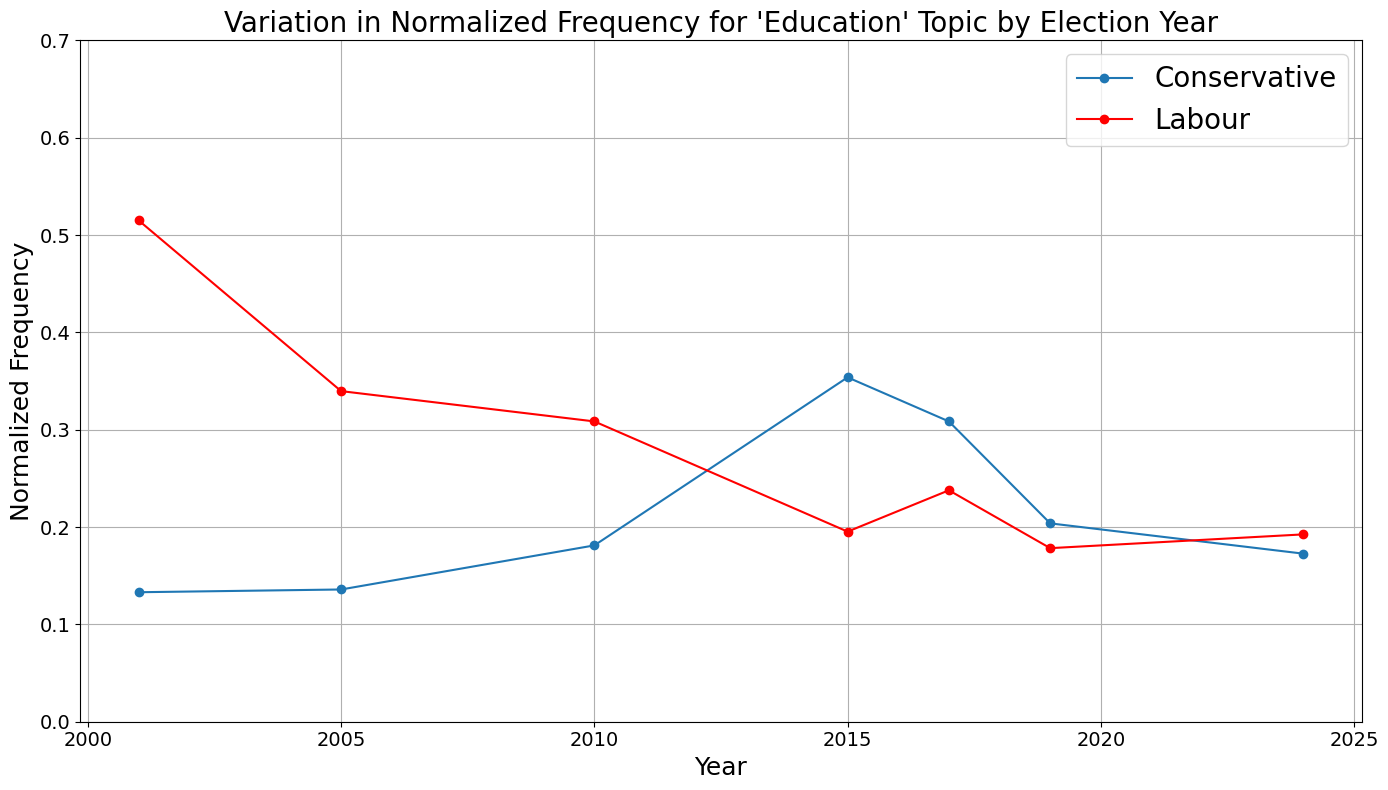

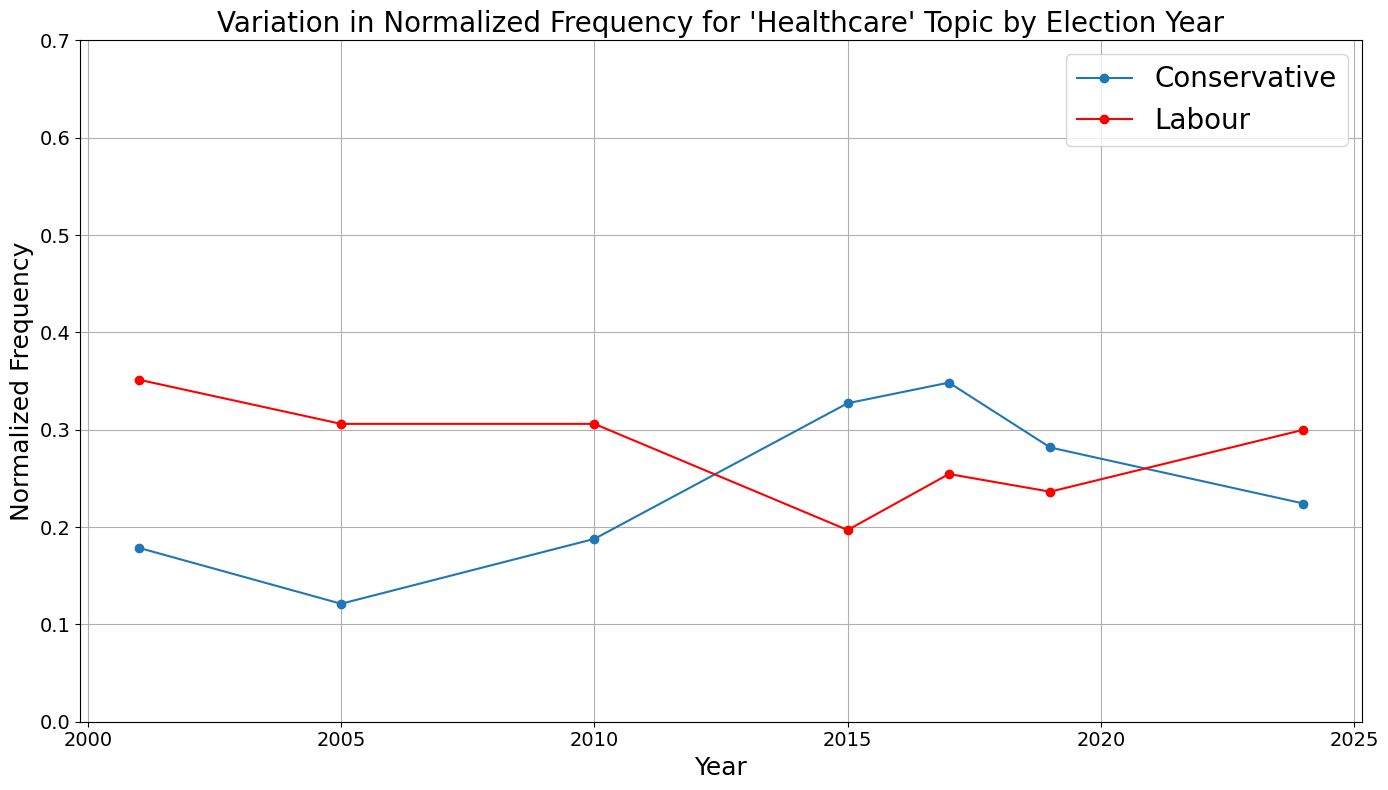

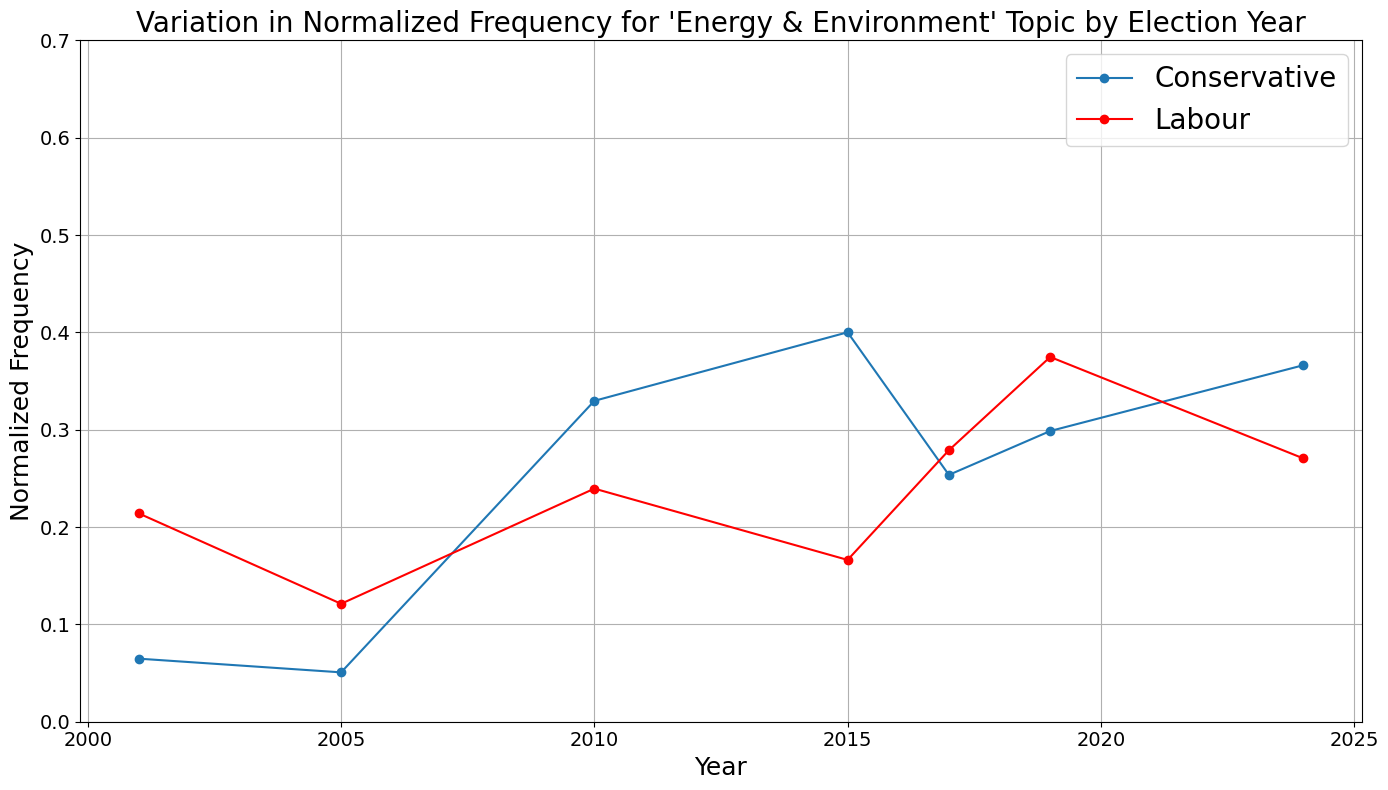

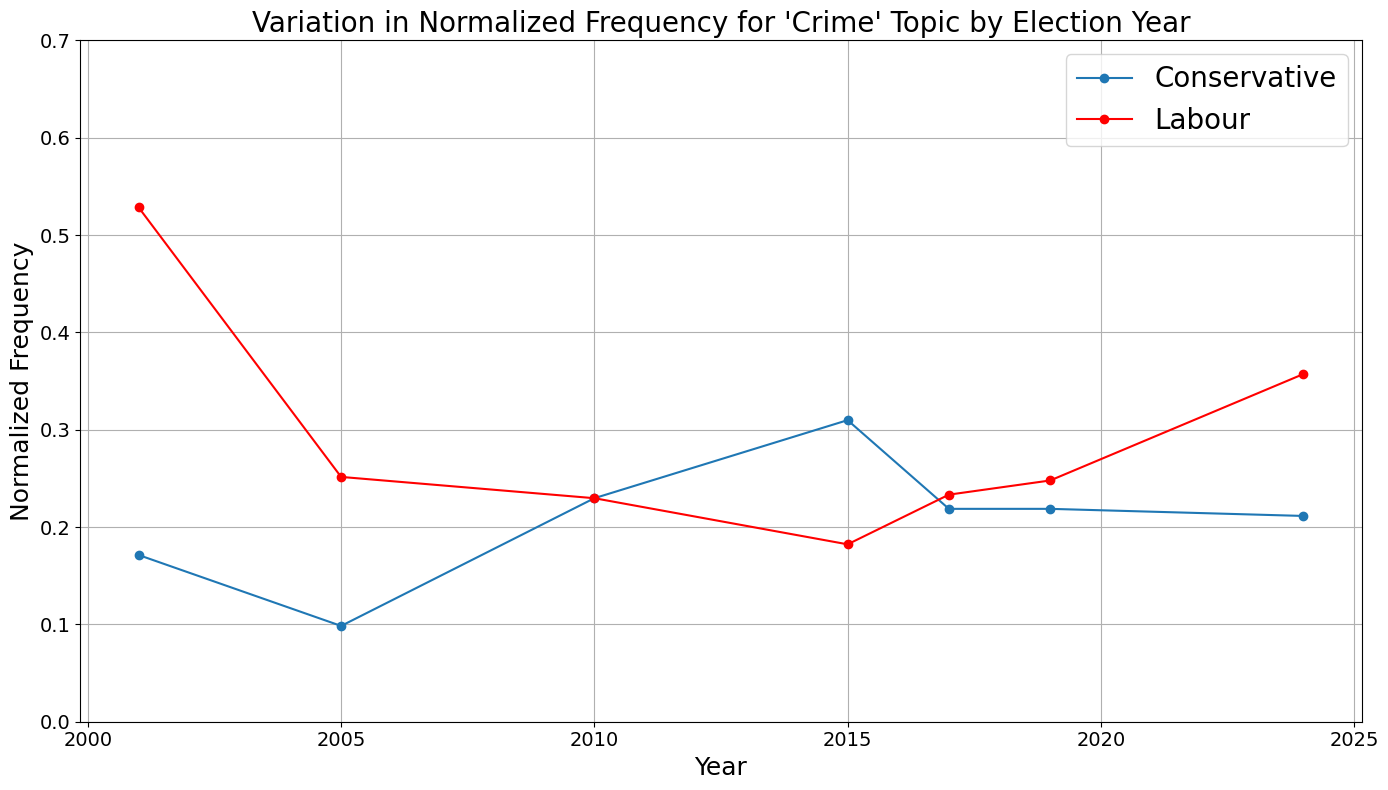

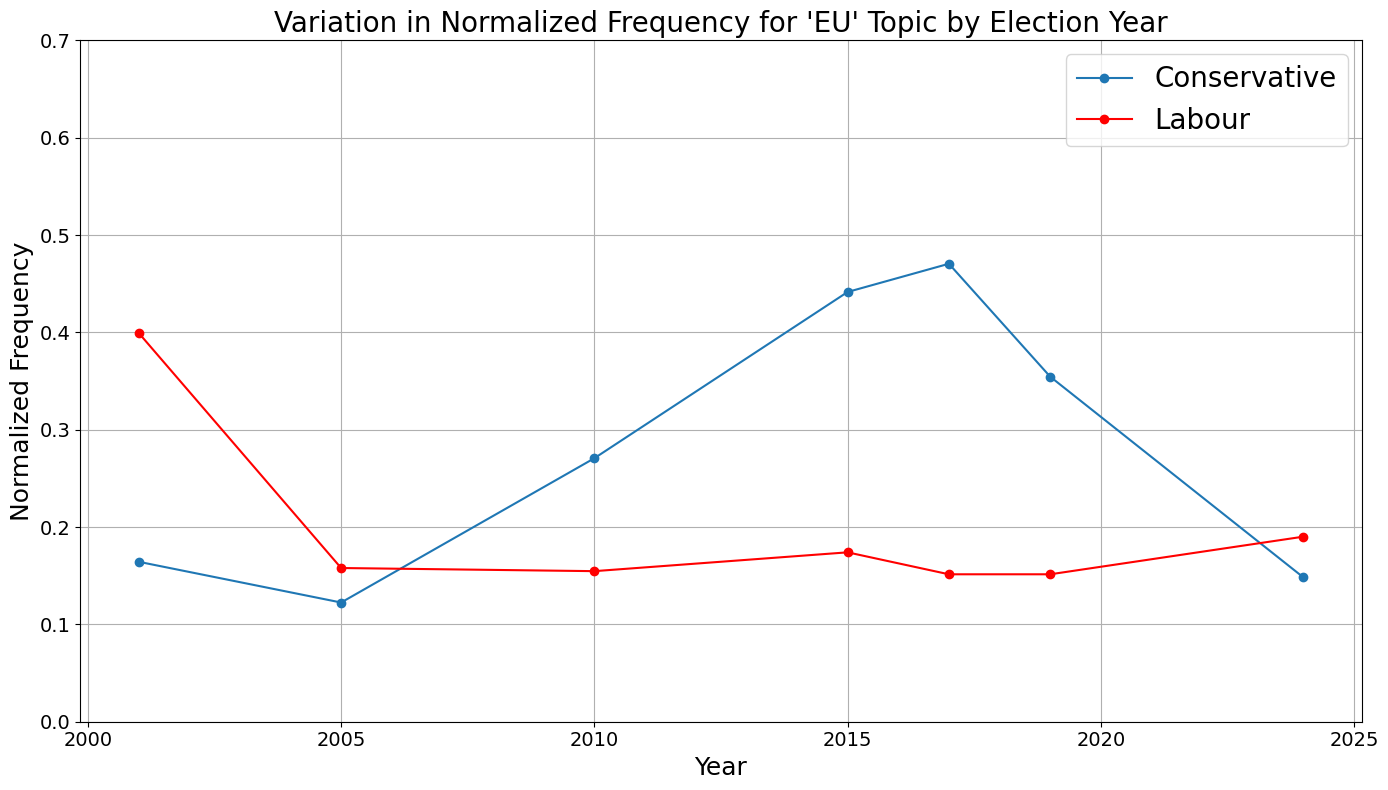

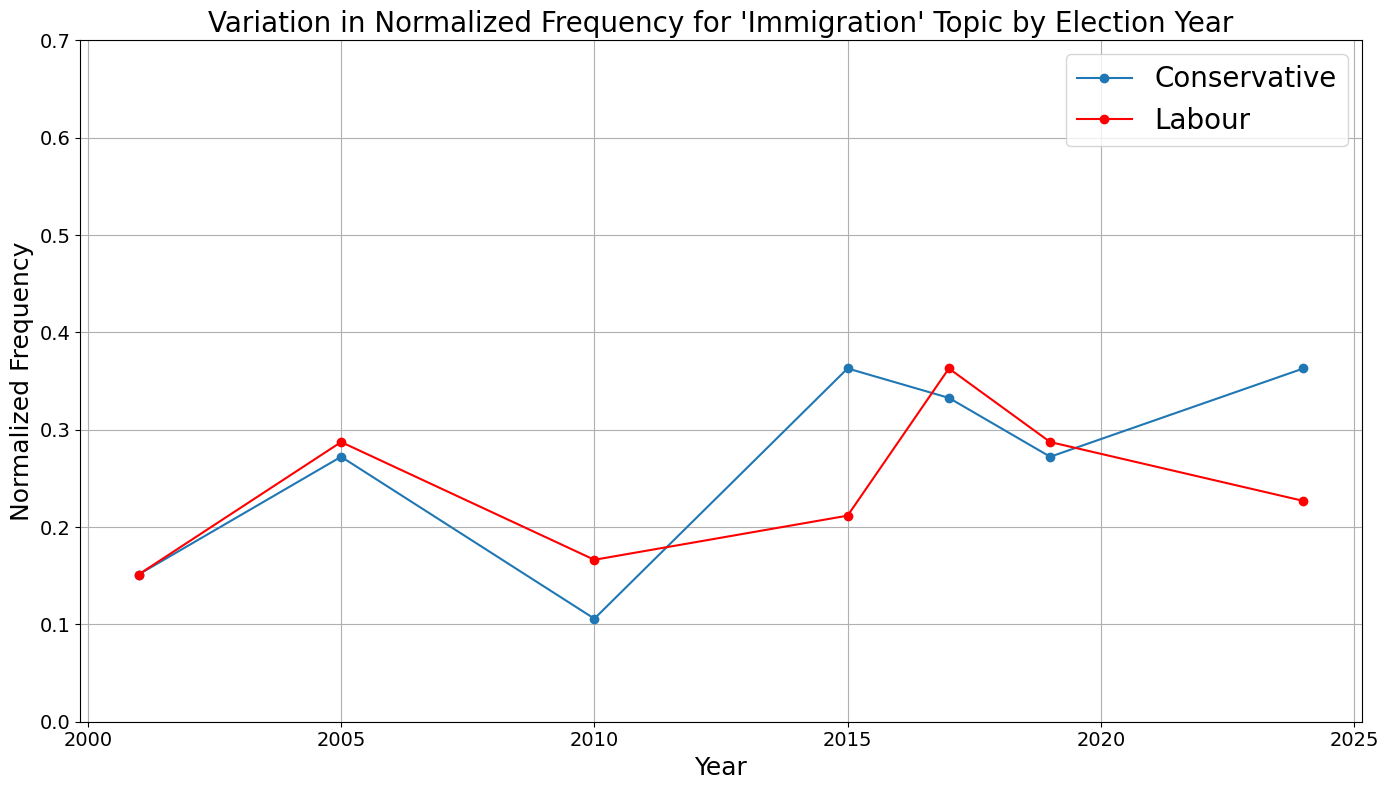

In [19]:
# Code generates normalised topic frequency plots for specified topics

# Specify the list of topic numbers you want to plot
topic_numbers = ['Education', 'Healthcare', 'Energy & Environment', 'Crime', 'EU', 'Immigration']  # Add the topic numbers you are interested in

# Loop through each topic number and create a plot
for topic_number in topic_numbers:
    # Filter the DataFrame for the selected topic
    topic_col = topic_number
    topic_df = normalized_df[['Party', 'Year', topic_col]]

    # Plotting
    plt.figure(figsize=(14, 8))
    for party in topic_df['Party'].unique():
        party_df = topic_df[topic_df['Party'] == party]
        if party == 'Lab':
            plt.plot(party_df['Year'], party_df[topic_col], marker='o', color='red', label=f'Labour')
        else:
            plt.plot(party_df['Year'], party_df[topic_col], marker='o', label=f'Conservative')

    plt.title(f"Variation in Normalized Frequency for '{topic_number}' Topic by Election Year", fontsize=20)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('Normalized Frequency', fontsize=18)
    plt.xticks(rotation=0, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=20)
    plt.grid(True)
    plt.ylim(0, 0.7)
    plt.tight_layout()
    plt.show()


# Stage 4 - Issue-specific Ideological Polarisation
- generates the cosine dissimilarity graphs used in figures 6,7,8 and 11
- generates the figure 9 graph that displays the cosine dissimilarity for Immigration between different embeddings types and the specific sentence examples used in figure 10.


In [20]:
# Import dataframe containing topic-labelled sentences
# Specify the folder path and file name
folder_path = "/content/drive/MyDrive/clean_manifestos/"
file_name = "tm_results.csv"

# Load the CSV file back into a DataFrame
tm_results = pd.read_csv(folder_path + file_name)


Cosine Dissimilarity of Education, Healthcare, Energy&Environment, Crime, EU and Immigration
(Figures 6,7,8 and 11)



Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

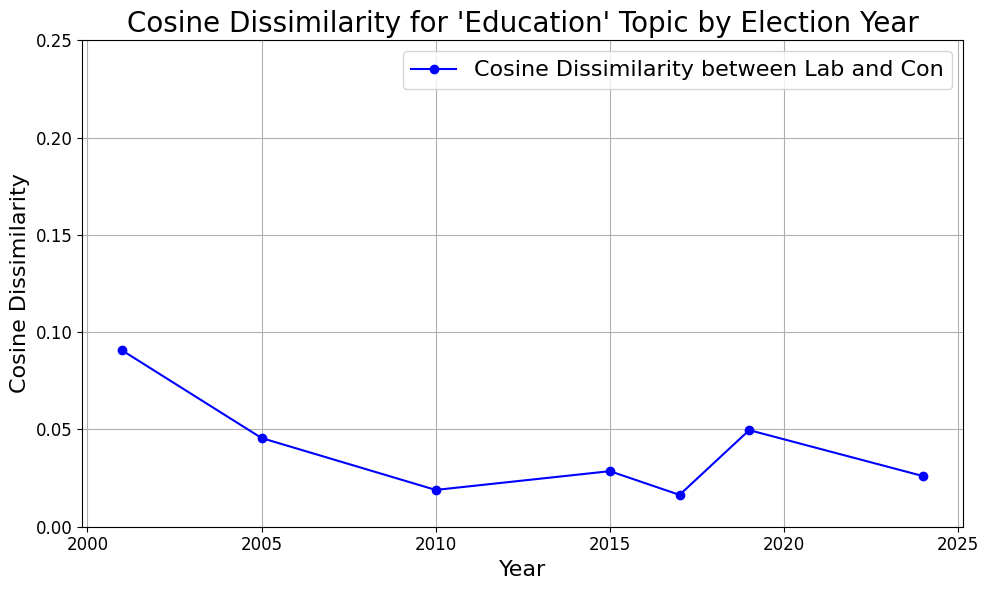

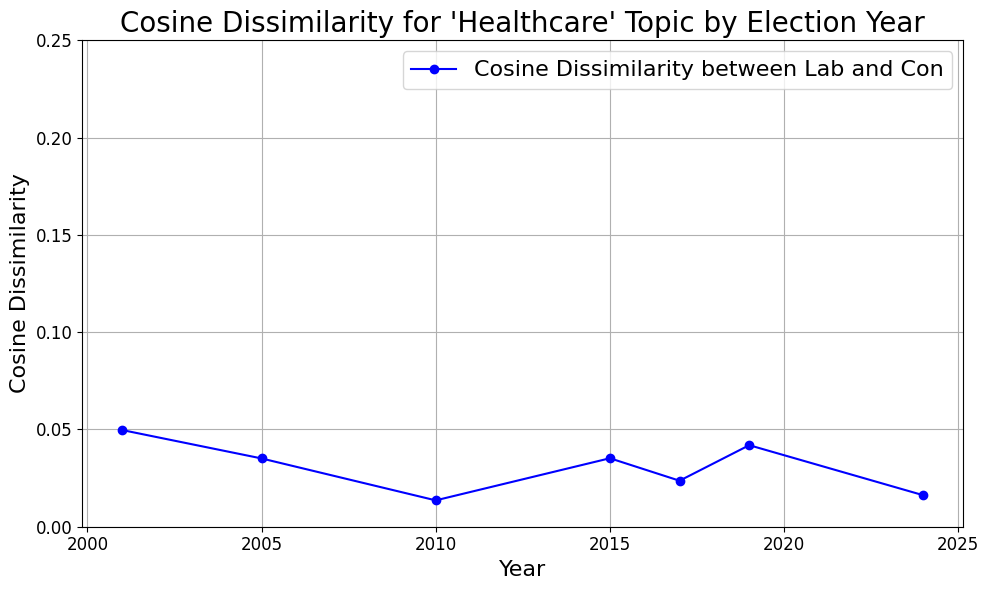

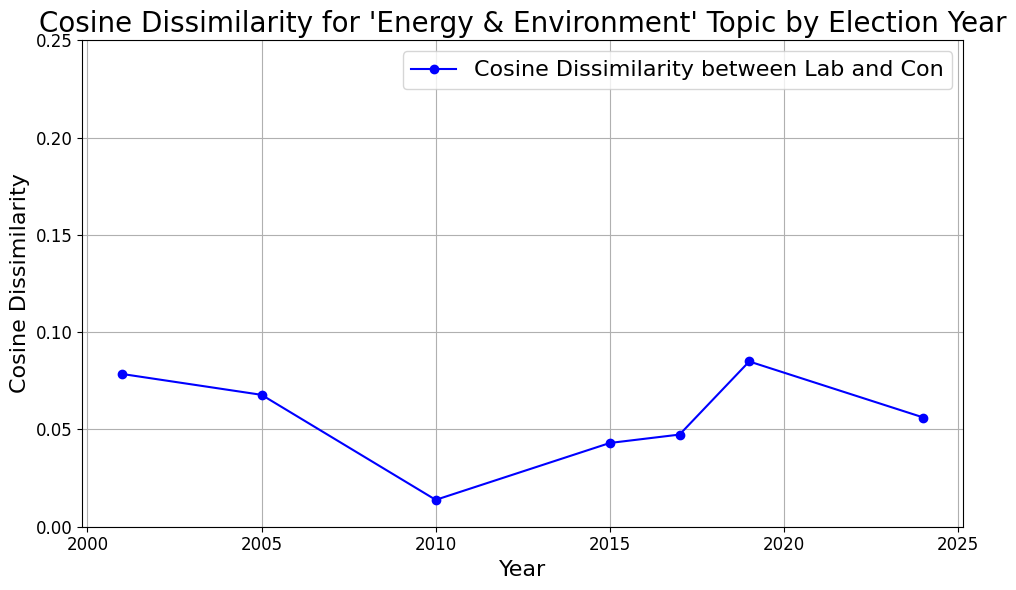

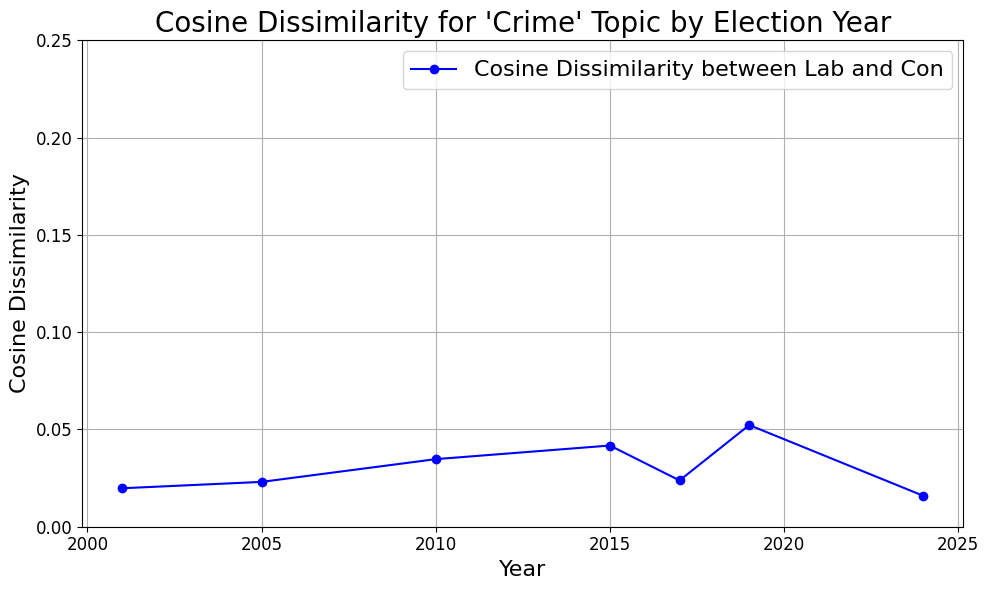

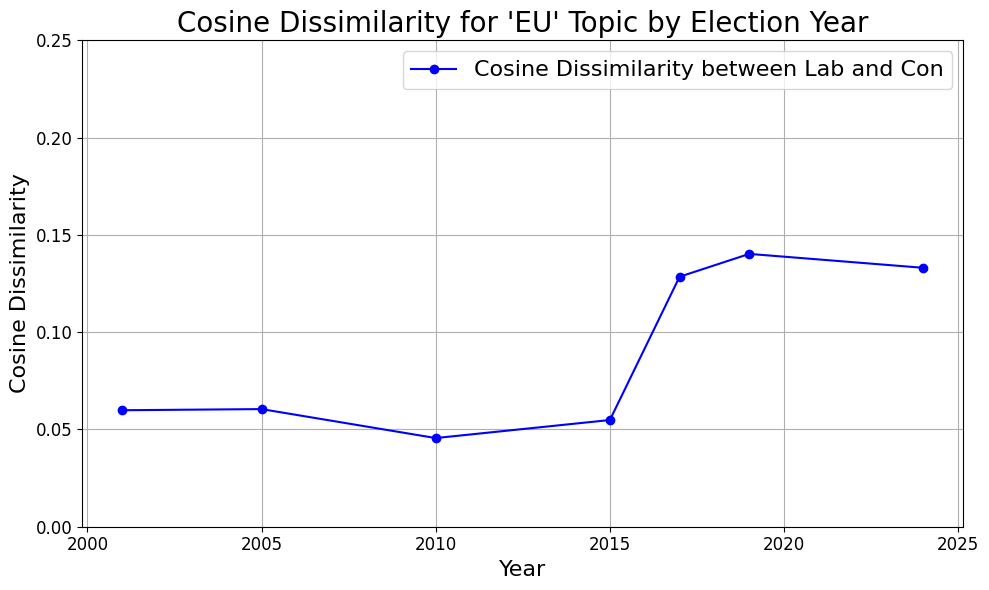

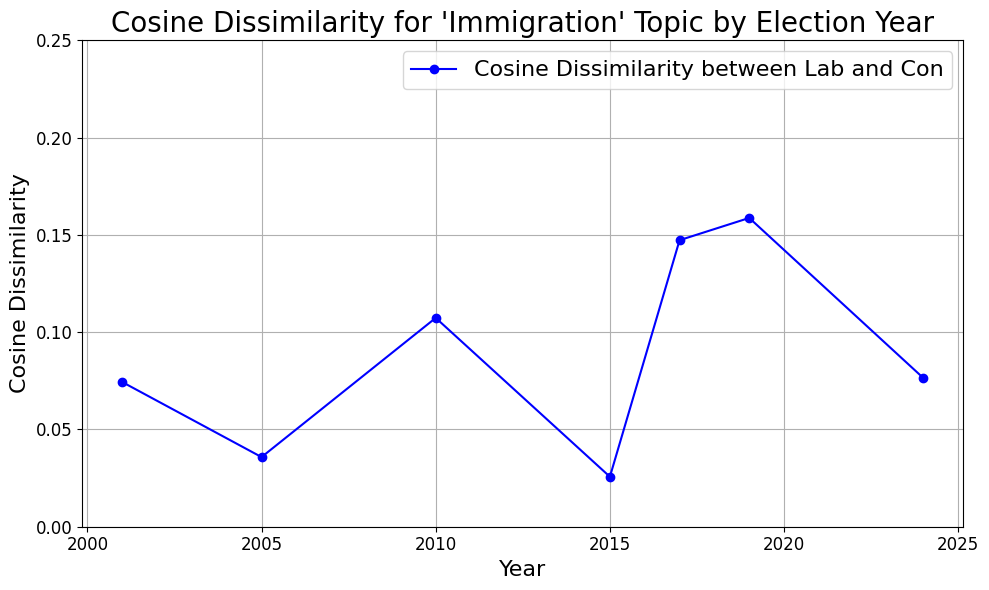

In [22]:
# Code generates cosine dissimilairty plots for specified topics

# Load the model and tokenizer, and move model to GPU if available
model_name = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Use the same model_name for the tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embedding_batch(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", max_length=200, padding="max_length", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Max pooling: Take the max value across the sequence dimension
    embeddings = outputs.hidden_states[-1].max(dim=1)[0].cpu().numpy()  # .max(dim=1) does the max pooling
    return embeddings


# Function to generate plots for multiple topics
def plot_cosine_dissimilarity_for_topics(df, topics):
    for topic in topics:
        # Filter the DataFrame for the specific topic
        df_topic = df[df['topic'] == topic].copy()

        # Get the topic label from the first row of the topic dataframe
        topic_label = df_topic['topic_label'].iloc[0] if not df_topic.empty else f'Topic {topic}'

        # Process sentences in batches
        batch_size = 16  # Adjust based on your system's memory capacity
        sentence_list = df_topic['sentence'].tolist()
        embeddings_list = []

        for i in range(0, len(sentence_list), batch_size):
            batch_sentences = sentence_list[i:i+batch_size]
            embeddings = get_embedding_batch(batch_sentences)
            embeddings_list.extend(embeddings)

        df_topic['embedding'] = embeddings_list

        # Group by year and party and calculate mean embeddings
        grouped_df = df_topic.groupby(['timestamp', 'party']).agg({'embedding': lambda x: np.mean(np.vstack(x), axis=0)}).reset_index()

        # Calculate cosine similarity between parties for each year
        results = {}
        for year in grouped_df['timestamp'].unique():
            con_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Con')]['embedding'].values
            lab_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Lab')]['embedding'].values

            if con_embedding.size > 0 and lab_embedding.size > 0:
                con_embedding = np.vstack(con_embedding)
                lab_embedding = np.vstack(lab_embedding)
                similarity = cosine_similarity(con_embedding, lab_embedding)[0][0]
                dissimilarity = 1 - similarity
                results[year] = dissimilarity

        # Plot the cosine dissimilarity over time for this topic
        years = sorted(results.keys())
        dissimilarities = [results[year] for year in years]

        plt.figure(figsize=(10, 6))
        plt.plot(years, dissimilarities, marker='o', linestyle='-', color='b', label=f"Cosine Dissimilarity between Lab and Con")
        plt.title(f"Cosine Dissimilarity for '{topic_label}' Topic by Election Year", fontsize = 20)
        plt.xlabel('Year', fontsize = 16)
        plt.ylabel('Cosine Dissimilarity', fontsize = 16)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.ylim([0, 0.25])  # Set the y-axis limits
        plt.grid(True)
        plt.legend(fontsize = 16)
        plt.tight_layout()
        plt.show()

# Specify the topic numbers of the topics being analysed
topics_to_analyze = [0,1,2,3,4,18]
# produce graphs for each topic
plot_cosine_dissimilarity_for_topics(tm_results, topics_to_analyze)


Cosine dissimilarity for Immigration: all-mpnet-base-v2 (general purpose) vs Manifestoberta (domain-specific) (Figure 9)

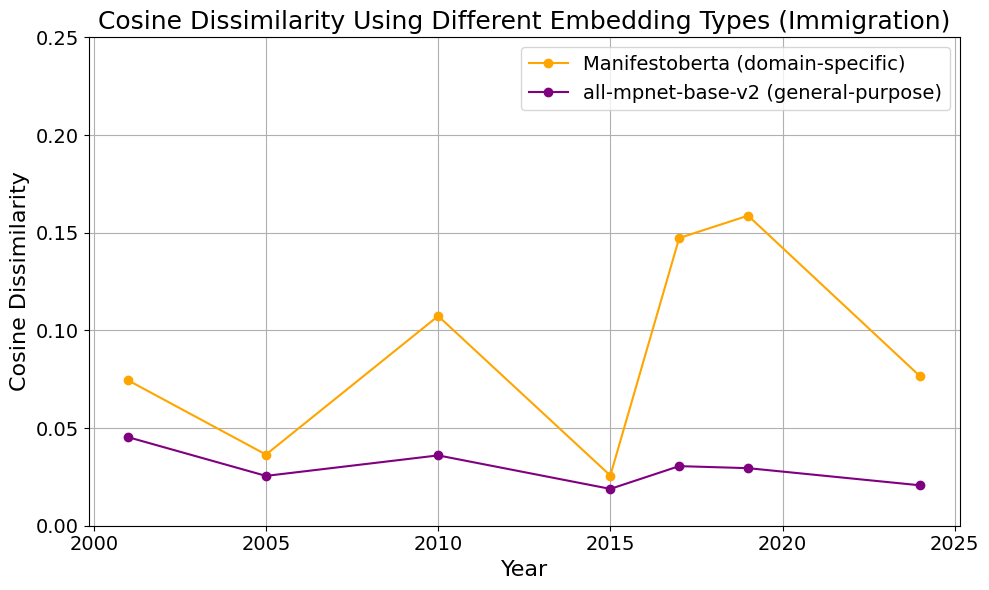

In [29]:
# Code produces the cosine dissimilarity graph for 'Immigration' topic using domain-specific and general-purpose models

# Load Manifestoberta model and tokenizer
manifesto_model_name = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1"
manifesto_model = AutoModelForSequenceClassification.from_pretrained(manifesto_model_name)
manifesto_tokenizer = AutoTokenizer.from_pretrained(manifesto_model_name)

# Load general embedding model and tokenizer
general_purpose_model_name = "sentence-transformers/all-mpnet-base-v2"
general_purpose_model = AutoModel.from_pretrained(general_purpose_model_name, output_hidden_states=True)
general_purpose_tokenizer = AutoTokenizer.from_pretrained(general_purpose_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
manifesto_model.to(device)
general_purpose_model.to(device)

def get_embedding_batch(sentences, model, tokenizer):
    inputs = tokenizer(sentences, return_tensors="pt", max_length=100, padding="max_length", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    embeddings = outputs.hidden_states[-1].max(dim=1)[0].cpu().numpy()  # Max pooling
    return embeddings

# Function to plot cosine dissimilarity for topic 18
def plot_cosine_dissimilarity_for_topic_18(df):
    topic = 18  # Only calculate for topic 18
    df_topic = df[df['topic'] == topic].copy()

    # Process sentences in batches for both models
    batch_size = 16  # Adjust based on your system's memory capacity
    sentence_list = df_topic['sentence'].tolist()

    manifesto_embeddings_list = []
    general_purpose_embeddings_list = []

    for i in range(0, len(sentence_list), batch_size):
        batch_sentences = sentence_list[i:i+batch_size]
        manifesto_embeddings = get_embedding_batch(batch_sentences, manifesto_model, manifesto_tokenizer)
        general_purpose_embeddings = get_embedding_batch(batch_sentences, general_purpose_model, general_purpose_tokenizer)

        manifesto_embeddings_list.extend(manifesto_embeddings)
        general_purpose_embeddings_list.extend(general_purpose_embeddings)

    df_topic['manifesto_embedding'] = manifesto_embeddings_list
    df_topic['general_purpose_embedding'] = general_purpose_embeddings_list

    # Group by year and party, calculate mean embeddings
    grouped_df = df_topic.groupby(['timestamp', 'party']).agg({'manifesto_embedding': lambda x: np.mean(np.vstack(x), axis=0),
                                                               'general_purpose_embedding': lambda x: np.mean(np.vstack(x), axis=0)}).reset_index()

    # Calculate cosine similarity between parties for each year for both models
    manifesto_results = {}
    general_purpose_results = {}

    for year in grouped_df['timestamp'].unique():
        con_manifesto_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Con')]['manifesto_embedding'].values
        lab_manifesto_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Lab')]['manifesto_embedding'].values

        con_general_purpose_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Con')]['general_purpose_embedding'].values
        lab_general_purpose_embedding = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == 'Lab')]['general_purpose_embedding'].values

        if con_manifesto_embedding.size > 0 and lab_manifesto_embedding.size > 0:
            con_manifesto_embedding = np.vstack(con_manifesto_embedding)
            lab_manifesto_embedding = np.vstack(lab_manifesto_embedding)
            manifesto_similarity = cosine_similarity(con_manifesto_embedding, lab_manifesto_embedding)[0][0]
            manifesto_dissimilarity = 1 - manifesto_similarity
            manifesto_results[year] = manifesto_dissimilarity

        if con_general_purpose_embedding.size > 0 and lab_general_purpose_embedding.size > 0:
            con_general_purpose_embedding = np.vstack(con_general_purpose_embedding)
            lab_general_purpose_embedding = np.vstack(lab_general_purpose_embedding)
            general_purpose_similarity = cosine_similarity(con_general_purpose_embedding, lab_general_purpose_embedding)[0][0]
            general_purpose_dissimilarity = 1 - general_purpose_similarity
            general_purpose_results[year] = general_purpose_dissimilarity

    # Plot the cosine dissimilarity over time for both models
    years = sorted(manifesto_results.keys())  # Assuming both models cover the same years
    manifesto_dissimilarities = [manifesto_results[year] for year in years]
    general_purpose_dissimilarities = [general_purpose_results[year] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, manifesto_dissimilarities, marker='o', linestyle='-', color='orange', label='Manifestoberta (domain-specific)')
    plt.plot(years, general_purpose_dissimilarities, marker='o', linestyle='-', color='purple', label='all-mpnet-base-v2 (general-purpose)')
    plt.title(f'Cosine Dissimilarity Using Different Embedding Types (Immigration)', fontsize = 18)
    plt.xlabel('Year', fontsize = 16)
    plt.ylabel('Cosine Dissimilarity', fontsize = 16)
    plt.xticks(rotation=0, fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim([0, 0.25])  # Set the y-axis limits
    plt.grid(True)
    plt.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()

# Example usage with the sentence DataFrame and topic 18
plot_cosine_dissimilarity_for_topic_18(tm_results)


Cosine dissimilarity comparison between general-purpose and domain-specific embeddings for specific Immigration sentences (figure 10)
- sentence pairs 2,3 and 4 are used in figure 10

In [30]:
# Code identifies the top 10 pairs of sentences from the 2015 Labour and Conservative manifestos with the greatest variation in cosine dissimilarity across different embedding types.
# Load Manifestobert model and tokenizer, and move model to GPU if available
manifesto_model_name = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1"
manifesto_model = AutoModelForSequenceClassification.from_pretrained(manifesto_model_name)
manifesto_tokenizer = AutoTokenizer.from_pretrained(manifesto_model_name)

# Load general_purpose model and tokenizer ()
general_purpose_model_name = "sentence-transformers/all-mpnet-base-v2"
general_purpose_model = AutoModel.from_pretrained(general_purpose_model_name, output_hidden_states=True)
general_purpose_tokenizer = AutoTokenizer.from_pretrained(general_purpose_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
manifesto_model.to(device)
general_purpose_model.to(device)

# Function to get embeddings using ManifestoBERT
def get_embedding_batch_manifesto(sentences):
    inputs = manifesto_tokenizer(sentences, return_tensors="pt", max_length=100, padding="max_length", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = manifesto_model(**inputs, output_hidden_states=True)
    # Max pooling: Take the max value across the sequence dimension
    embeddings = outputs.hidden_states[-1].max(dim=1)[0].cpu().numpy()  # .max(dim=1) does the max pooling
    return embeddings

# Function to get embeddings using general_purpose
def get_embedding_batch_general_purpose(sentences):
    inputs = general_purpose_tokenizer(sentences, return_tensors="pt", max_length=100, padding="max_length", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = general_purpose_model(**inputs)
    # Max pooling: Take the max value across the sequence dimension
    embeddings = outputs.hidden_states[-1].max(dim=1)[0].cpu().numpy()  # .max(dim=1) does the max pooling
    return embeddings

# Main function to find top sentence pairs with the largest cosine dissimilarity differences
def find_top_diff_sentences(df, topic):
    # Filter the DataFrame for the specific topic and year 2015
    df_topic = df[(df['topic'] == topic) & (df['timestamp'] == 2015)].copy()

    if df_topic.empty:
        print(f"No data available for Topic {topic} in 2015.")
        return

    # Process sentences in batches
    batch_size = 16  # Adjust based on your system's memory capacity
    sentence_list = df_topic['sentence'].tolist()

    manifesto_embeddings_list = []
    general_purpose_embeddings_list = []

    # Get embeddings for ManifestoBERT and general_purpose in batches
    for i in range(0, len(sentence_list), batch_size):
        batch_sentences = sentence_list[i:i+batch_size]
        manifesto_embeddings = get_embedding_batch_manifesto(batch_sentences)
        general_purpose_embeddings = get_embedding_batch_general_purpose(batch_sentences)

        manifesto_embeddings_list.extend(manifesto_embeddings)
        general_purpose_embeddings_list.extend(general_purpose_embeddings)

    df_topic['manifesto_embedding'] = manifesto_embeddings_list
    df_topic['general_purpose_embedding'] = general_purpose_embeddings_list

    # Iterate through the selected year (2015)
    df_year = df_topic[df_topic['timestamp'] == 2015]

    con_sentences = df_year[df_year['party'] == 'Con'][['sentence', 'manifesto_embedding', 'general_purpose_embedding']]
    lab_sentences = df_year[df_year['party'] == 'Lab'][['sentence', 'manifesto_embedding', 'general_purpose_embedding']]

    # Calculate pairwise cosine dissimilarities between all sentences of Con and Lab
    dissimilarity_diffs = []

    for con_idx, con_row in con_sentences.iterrows():
        for lab_idx, lab_row in lab_sentences.iterrows():
            # Calculate cosine dissimilarity for ManifestoBERT embeddings
            manifesto_similarity = cosine_similarity([con_row['manifesto_embedding']], [lab_row['manifesto_embedding']])[0][0]
            manifesto_dissimilarity = 1 - manifesto_similarity

            # Calculate cosine dissimilarity for general_purpose embeddings
            general_purpose_similarity = cosine_similarity([con_row['general_purpose_embedding']], [lab_row['general_purpose_embedding']])[0][0]
            general_purpose_dissimilarity = 1 - general_purpose_similarity

            # Calculate the absolute difference in cosine dissimilarity between general_purpose and ManifestoBERT
            dissimilarity_diff = abs(manifesto_dissimilarity - general_purpose_dissimilarity)

            dissimilarity_diffs.append((con_row['sentence'], lab_row['sentence'], manifesto_dissimilarity, general_purpose_dissimilarity, dissimilarity_diff))

    # Sort by the difference in cosine dissimilarity and take the top 10 pairs
    top_diffs = sorted(dissimilarity_diffs, key=lambda x: x[4], reverse=True)[:10]

    # Output the results for the top 10 pairs with the largest difference
    print(f"\nTopic: {topic}, Year: 2015 - Top 10 pairs with largest difference in cosine dissimilarity")
    for idx, (con_sentence, lab_sentence, manifesto_dissimilarity, general_purpose_dissimilarity, dissimilarity_diff) in enumerate(top_diffs):
        print(f"Pair {idx + 1}:")
        print(f"Conservative: {con_sentence}")
        print(f"Labour: {lab_sentence}")
        print(f"Cosine Dissimilarity for Manifestoberta (domain-specific): {manifesto_dissimilarity:.4f}")
        print(f"Cosine Dissimilarity for all-mpnet-base-v2 (general purpose): {general_purpose_dissimilarity:.4f}")
        print(f"Difference in Cosine Dissimilarity: {dissimilarity_diff:.4f}")
        print("-" * 40)

# Example usage with a specific topic
topic_to_analyze = 18  # Replace with the topic number you want to analyze
find_top_diff_sentences(tm_results, topic_to_analyze)



Topic: 18, Year: 2015 - Top 10 pairs with largest difference in cosine dissimilarity
Pair 1:
Conservative: We will reduce the number of people coming to our country with tough new welfare conditions and robust enforcement.
Labour: We will end the indefinite detention of people in the asylum and immigration system,
Cosine Dissimilarity for Manifestoberta (domain-specific): 0.7958
Cosine Dissimilarity for all-mpnet-base-v2 (general purpose): 0.1820
Difference in Cosine Dissimilarity: 0.6138
----------------------------------------
Pair 2:
Conservative: enhance our border security and strengthen the enforcement of immigration rules
Labour: Immigration has made an important contribution to our economic and social life,
Cosine Dissimilarity for Manifestoberta (domain-specific): 0.7905
Cosine Dissimilarity for all-mpnet-base-v2 (general purpose): 0.2213
Difference in Cosine Dissimilarity: 0.5692
----------------------------------------
Pair 3:
Conservative: We also know that immigration mus

Cosine Dissimilarity *within-party* for Immigration (Figure 11)

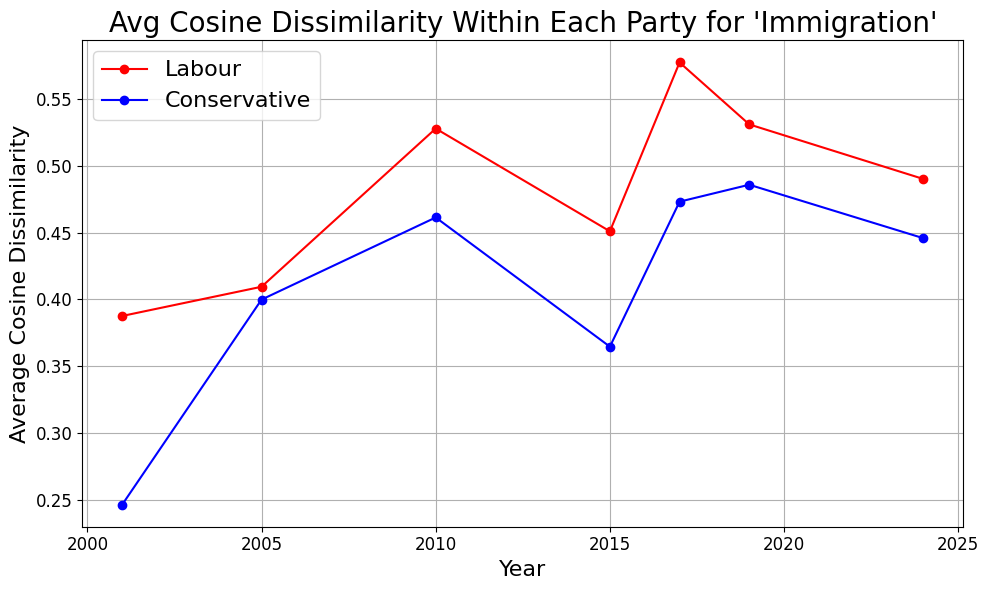

In [34]:
# Load the model and tokenizer, and move model to GPU if available
model_name = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)  # Use the same model_name for the tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_embedding_batch(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", max_length=200, padding="max_length", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Max pooling: Take the max value across the sequence dimension
    embeddings = outputs.hidden_states[-1].max(dim=1)[0].cpu().numpy()  # .max(dim=1) does the max pooling
    return embeddings

def plot_cosine_dissimilarity_within_party(df, topics):
    for topic in topics:
        # Filter the DataFrame for the specific topic
        df_topic = df[df['topic'] == topic].copy()

        # Get the topic label from the first row of the topic dataframe
        topic_label = df_topic['topic_label'].iloc[0] if not df_topic.empty else f'Topic {topic}'

        # Process sentences in batches
        batch_size = 16  # Adjust based on your system's memory capacity
        sentence_list = df_topic['sentence'].tolist()
        embeddings_list = []

        for i in range(0, len(sentence_list), batch_size):
            batch_sentences = sentence_list[i:i+batch_size]
            embeddings = get_embedding_batch(batch_sentences)
            embeddings_list.extend(embeddings)

        df_topic['embedding'] = embeddings_list

        # Group by year and party
        grouped_df = df_topic.groupby(['timestamp', 'party']).agg({'embedding': list}).reset_index()

        results = {'Lab': {}, 'Con': {}}

        # Calculate the average cosine dissimilarity within each party for each year
        for year in grouped_df['timestamp'].unique():
            for party in ['Lab', 'Con']:
                party_embeddings = grouped_df[(grouped_df['timestamp'] == year) & (grouped_df['party'] == party)]['embedding'].values

                if len(party_embeddings) > 0:
                    party_embeddings = np.vstack(party_embeddings[0])  # Flatten the list of embeddings for the party
                    dissimilarities = []

                    # Calculate pairwise cosine dissimilarities within the party
                    for i in range(len(party_embeddings)):
                        for j in range(i+1, len(party_embeddings)):
                            similarity = cosine_similarity([party_embeddings[i]], [party_embeddings[j]])[0][0]
                            dissimilarity = 1 - similarity
                            dissimilarities.append(dissimilarity)

                    # Store the average dissimilarity for the party and year
                    if dissimilarities:
                        results[party][year] = np.median(dissimilarities)

        # Plot the average cosine dissimilarity over time for each party
        years = sorted(list(set(list(results['Lab'].keys()) + list(results['Con'].keys()))))
        lab_dissimilarities = [results['Lab'].get(year, np.nan) for year in years]
        con_dissimilarities = [results['Con'].get(year, np.nan) for year in years]

        plt.figure(figsize=(10, 6))
        plt.plot(years, lab_dissimilarities, marker='o', linestyle='-', color='red', label='Labour')
        plt.plot(years, con_dissimilarities, marker='o', linestyle='-', color='blue', label='Conservative')

        plt.title(f"Avg Cosine Dissimilarity Within Each Party for '{topic_label}'", fontsize=20)
        plt.xlabel('Year', fontsize=16)
        plt.ylabel('Average Cosine Dissimilarity', fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True)
        plt.legend(fontsize=16)
        plt.tight_layout()
        plt.show()

# Example usage with a list of topics
topics_to_analyze = [18]
plot_cosine_dissimilarity_within_party(tm_results, topics_to_analyze)
